In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [154]:
humans = pd.read_csv("data/humans.csv")
machines = pd.read_csv("data/machines.csv")
machines = machines.iloc[machines["text"].drop_duplicates().index]
df = pd.concat([humans,machines])
df.drop(columns=["profundidade_max","profundidade_media"],inplace=True)
variable_mapping = {
    'lexical_density': 'LD',
    'lexical_sophistication': 'LS',
    'ttr': 'TTR',
    'd-measure': 'D',
    'token_quantity': 'token_count'
}
df.rename(columns=variable_mapping, inplace=True)

In [155]:
len(humans)

61

In [156]:
df["type"]

0         False
1         False
2         False
3         False
4         False
         ...   
295    maritalk
296    maritalk
297    maritalk
298    maritalk
299    maritalk
Name: type, Length: 361, dtype: object

In [157]:
df["type"].unique()

array([False, True, 'gpt-3.5-turbo', 'gpt-4', 'maritalk'], dtype=object)

In [158]:
mapp = {x:x for x in df["type"].unique()}
mapp[False] = "not maximum grade"
mapp[True]  = "maximum grade"

In [159]:
df["type"] = df["type"].map(mapp)

In [160]:
df["type"].unique()

array(['not maximum grade', 'maximum grade', 'gpt-3.5-turbo', 'gpt-4',
       'maritalk'], dtype=object)

In [161]:
mapp = {s:"LLM" for s in  df["type"].unique()}
mapp["not maximum grade"] = "human"
mapp["maximum grade"] = "human"
df["model"] = df["type"].map(mapp)

In [162]:
df.sample(11).head()

,MLC,MLS,MLT,DCC,DCT,CPC,CPT,TS,LD,LS,TTR,D,token_count,text,type,model
4,16.136364,25.357143,35.50,0.454545,1.000,0.772727,1.700,0.714286,0.411268,0.843750,0.565079,151.416285,355,"Desde o Brasil Colônia, com a chegada dos port...",not maximum grade,human
159,24.250000,34.235294,72.75,0.625000,1.875,3.541667,10.625,0.470588,0.393471,0.942857,0.403670,89.936678,582,Título: Desafios e Valorização das Comunidades...,gpt-3.5-turbo,LLM
227,14.206897,29.428571,82.40,0.655172,3.800,2.413793,14.000,0.357143,0.432039,0.975610,0.502604,123.824192,412,A valorização das comunidades e povos tradicio...,gpt-3.5-turbo,LLM
180,24.050000,30.062500,48.10,0.850000,1.700,2.900000,5.800,0.625000,0.419958,0.970588,0.518605,106.128642,481,TÍTULO: Valorização dos povos tradicionais: um...,gpt-4,LLM
260,19.718750,35.055556,63.10,0.656250,2.100,1.875000,6.000,0.555556,0.380349,0.860465,0.444444,116.646813,631,Título: Valorização das Comunidades Tradiciona...,gpt-4,LLM


In [163]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby("type")[numeric_columns].agg(["mean", "std"]).round(1)

MLC        MLS         MLT        DCC       DCT       ...  \
                   mean  std  mean   std  mean   std mean  std mean  std  ...   
type                                                                      ...   
gpt-3.5-turbo      21.6  4.7  34.7   5.0  98.1  40.0  0.7  0.1  3.3  1.7  ...   
gpt-4              20.6  4.1  32.7   4.9  58.7  15.5  0.7  0.1  1.9  0.7  ...   
maritalk           23.4  5.5  30.5   6.3  76.0  29.7  0.7  0.1  2.4  1.0  ...   
maximum grade      19.7  3.9  43.4   7.2  59.5  13.9  0.7  0.1  2.2  0.8  ...   
not maximum grade  16.7  4.8  37.4  10.4  58.9  23.5  0.6  0.1  2.4  1.5  ...   

                    LD        LS       TTR           D       token_count  \
                  mean  std mean  std mean  std   mean   std        mean   
type                                                                       
gpt-3.5-turbo      0.4  0.0  0.9  0.0  0.5  0.0  106.2  12.3       477.8   
gpt-4              0.4  0.0  0.9  0.0  0.5  0.0  127.2  18.8       536.5   
maritalk           0.4  0.0  0.9  0.1  0.5  0.0  114.7  14.6       382.1   
maximum grade      0.4  0.0  0.9  0.0  0.5  0.0  113.5  11.5       650.0   
not maximum grade  0.4  0.0  0.9  0.0  0.5  0.1  136.2  26.7       412.8   

                          
                     std  
type                      
gpt-3.5-turbo       62.4  
gpt-4               65.2  
maritalk            16.4  
maximum grade       80.5  
not maximum grade  120.7  

[5 rows x 26 columns]

In [164]:
# sns.pairplot(df,hue="model",diag_kind = "kde")

In [165]:
# sns.pairplot(df,hue="type")

In [166]:
mapp = {s:"LLM" for s in  df["type"].unique()}
mapp["not maximum grade"] = "human"
mapp["maximum grade"] = "human"
df["model"] = df["type"].map(mapp)

In [167]:
df["class"] = ((df["model"] == "LLM") * df["type"]) + ((df["model"] != "LLM") * df["model"]) 

In [168]:
from scipy.stats import ttest_ind

grouped_data = df.groupby('class')

group1 = grouped_data.get_group("human")

classes = df["class"].unique()
classes = [c for c in classes if c != "human"]

ttest_results = {
    'Feature': [],
}

for c in classes:
    ttest_results["human vs " + c] = []

alpha = 0.05  # Significance level before Bonferroni correction

for column in df.select_dtypes(include='number').columns:
    # Extract the data for group1 for the current column
    data1 = group1[column]
    ttest_results['Feature'].append(column)

    
    for class_label in classes:
        group2 = grouped_data.get_group(class_label)
        data2 = group2[column].sample(30)
        
        # Perform the t-test
        t_stat, p_value = ttest_ind(data1, data2)
        
        # Determine if the result is significant (p-value < 0.05)
        significant = p_value < alpha
        # Store the p-value for this class comparison
        ttest_results["human vs " + class_label].append(significant)
        

results_df = pd.DataFrame(ttest_results)

In [169]:
lexical_features = ["LD","LS","TTR","D"]

In [170]:
cols =["human vs " + c for c in classes]
results_df["ALL"] = results_df[cols].all(axis=1)

In [171]:
significant_ones = results_df[results_df["ALL"]]["Feature"]
significant_ones

1    MLS
5    CPC
6    CPT
7     TS
Name: Feature, dtype: object

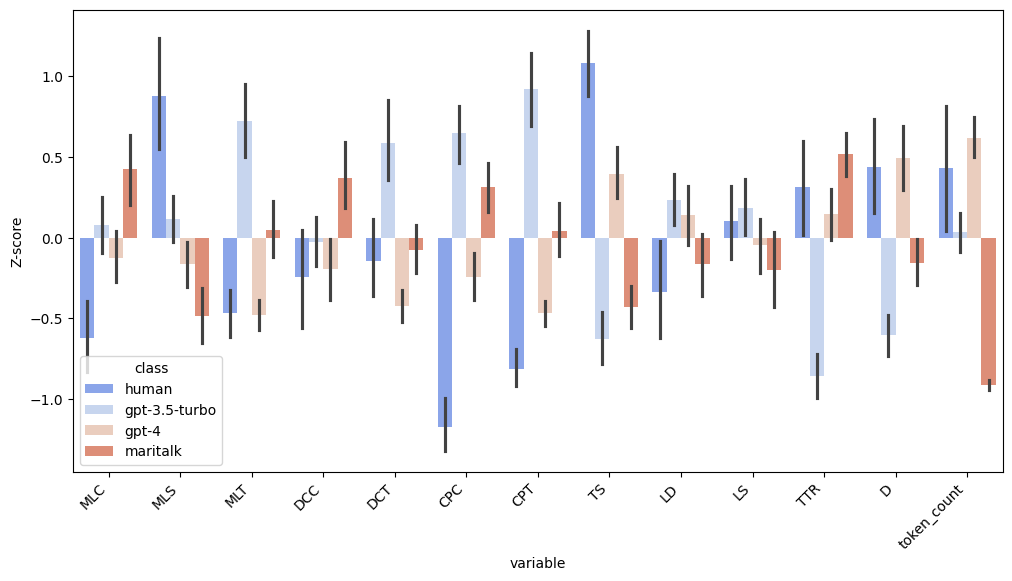

In [172]:
# Plotting
z_scores = df[df.select_dtypes(include='number').columns].apply(lambda x: (x - x.mean()) / x.std())
z_scores["class"] = df["class"]
z_scores_melted  = z_scores.melt(id_vars="class", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))
sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="class", palette="coolwarm",errorbar="ci")
# plt.xlabel("Variable")
plt.ylabel("Z-score")
# plt.title("Z-score of each variable for each type")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()


In [173]:
df.groupby("class")["token_count"].mean(),df.groupby("class")["token_count"].std()

(class
 gpt-3.5-turbo    477.770000
 gpt-4            536.510000
 human            517.770492
 maritalk         382.140000
 Name: token_count, dtype: float64,
 class
 gpt-3.5-turbo     62.444457
 gpt-4             65.226024
 human            157.920591
 maritalk          16.371952
 Name: token_count, dtype: float64)

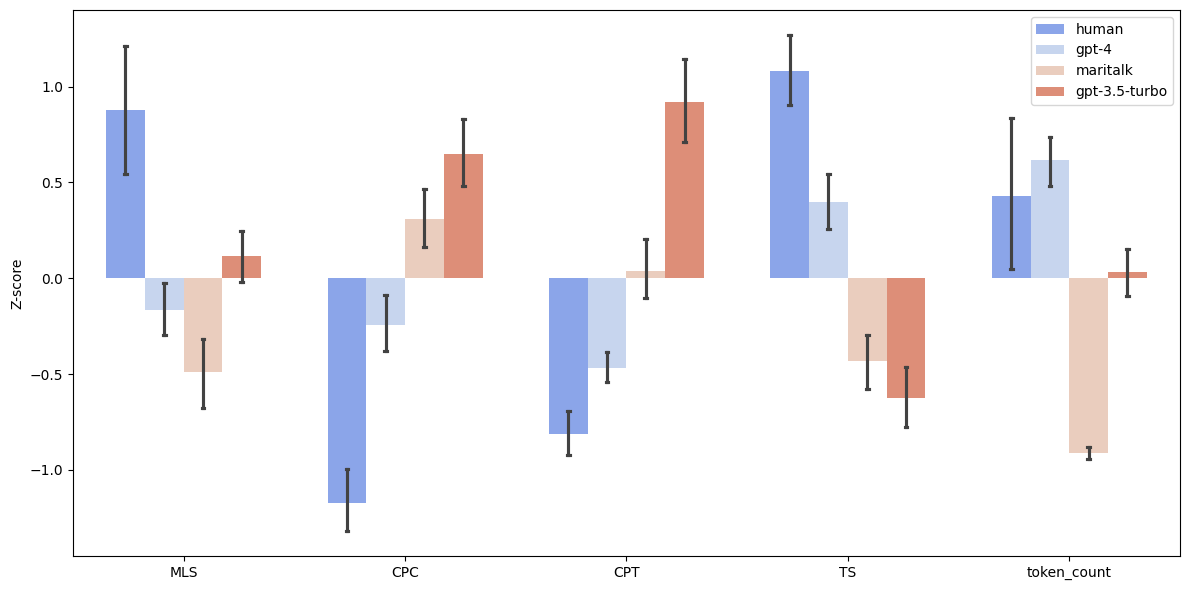

In [179]:
# Plotting
z_scores = df[significant_ones.to_list() + ["token_count"]].apply(lambda x: (x - x.mean()) / x.std())
z_scores["class"] = df["class"]
z_scores_melted  = z_scores.melt(id_vars="class", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))

hue_order = ["human","gpt-4","maritalk",  "gpt-3.5-turbo"]

custom_palette = ["#A0B4EB","#B0A4EB", "#BDCBF1", "#DBA38D"]  # Example colors

sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="class", 
            palette="coolwarm",
            hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.7)
plt.xlabel("")
plt.ylabel("Z-score")
plt.tight_layout()
plt.legend(title="")

# plt.savefig("Statistical Divergent Features for humans.pdf", format="pdf")

plt.show()


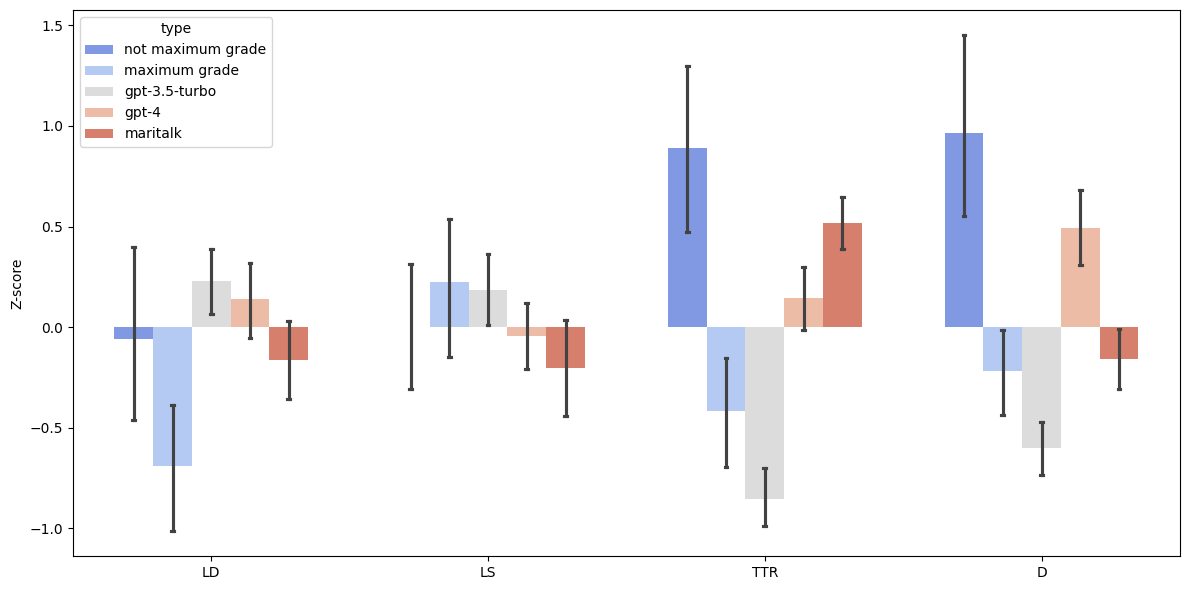

In [175]:
# Plotting
z_scores = df[lexical_features].apply(lambda x: (x - x.mean()) / x.std())
z_scores["type"] = df["type"]
z_scores_melted  = z_scores.melt(id_vars="type", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))

hue_order = ["human","gpt-4","maritalk",  "gpt-3.5-turbo"]

custom_palette = ["#A0B4EB","#B0A4EB", "#BDCBF1", "#DBA38D"]  # Example colors

sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="type", 
            palette="coolwarm",
            # hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.7)
plt.xlabel("")
plt.ylabel("Z-score")
plt.tight_layout()
plt.show()


In [176]:
df["class_2"] = ((df["model"] == "LLM") * df["model"]) + ((df["model"] != "LLM") * df["type"]) 
df["class_2"].unique()

array(['not maximum grade', 'maximum grade', 'LLM'], dtype=object)

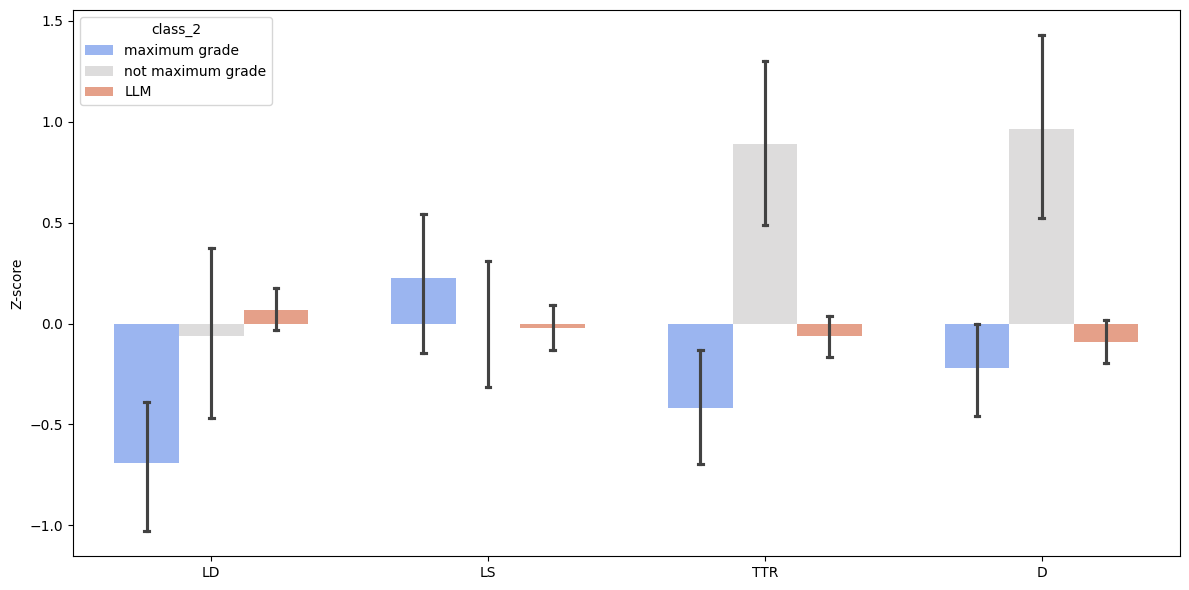

In [177]:
# Plotting
z_scores = df[lexical_features].apply(lambda x: (x - x.mean()) / x.std())
z_scores["class_2"] = df["class_2"]
z_scores_melted  = z_scores.melt(id_vars="class_2", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))

hue_order = ["maximum grade","not maximum grade","LLM"]

custom_palette = ["#A0B4EB","#B0A4EB", "#BDCBF1", "#DBA38D"]  # Example colors

sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="class_2", 
            palette="coolwarm",
            hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.7)
plt.xlabel("")
plt.ylabel("Z-score")
plt.tight_layout()
plt.show()
